In [94]:
import tensorflow as tf
from __future__ import print_function
import numpy as np


## A1 Q1
Euclidean distance function, vectorized    

In [90]:
def euclideanDistance(x, z):
    '''
    We vectorized the operation with matrix operations
    the ||x - z ||^2 is = Sum(x - z)^2 = Sum from 1 to D
    of (x^2 - 2xz + z^2)
    
    x^2 = x^T times x
    z^2 = z^T times z
    we can find the sum of each row by using the reduce sum function
    
    sum of -2xz 
    we can use matrix multiplication, x times z^T to obtain xz,
    then multiply by -2
    '''
    n1 = x.shape[0]
    n2 = z.shape[0]    
    
    x_squared = tf.square(x)
    z_squared = tf.square(z) #tf.matmul(z ,tf.transpose(z))
    #print("x_squared.eval()")
    #print(x_squared.eval())
    x_2_sum = tf.reduce_sum(x_squared, 1)
    z_2_sum = tf.reduce_sum(z_squared, 1)
    
    x_2_sum = tf.transpose(x_2_sum)
    z_2_sum = tf.transpose(z_2_sum)
    #x_2_sum = tf.reshape(x_2_sum, [-1, 1])
    #z_2_sum = tf.reshape(z_2_sum, [-1, 1])
    #print("x_2_sum.eval()")
    #print(x_2_sum.eval())
    
    xz = tf.matmul(x, tf.transpose(z))
    #print(xz.eval())
    minus_2xz = tf.scalar_mul(-2, xz)
    #print(minus_2xz.eval())
 
    x_2_tile =tf.tile(tf.expand_dims(x_2_sum, 1), [1, n2])
    z_2_tile = tf.tile(tf.expand_dims(z_2_sum ,1), [1, n1])
    z_2_tile_T = tf.transpose(z_2_tile)
    #print(x_2_tile.eval())
    #print(z_2_tile_T.eval())
    
    result = x_2_tile + minus_2xz +z_2_tile_T
    
    return result

"""VERIFIED"""

def testi():
    A = tf.constant([[1, 1], [2,2], [3, 3], [4,4]])
    B = tf.constant([[1, 1], [2, 2],[3,3]])
    res_mine = euclideanDistance(A, B)
    
    print("----my func----")
    print(res_mine.eval())
    print("---diff square---")
    res_lib = PairwiseDistances(A, B)
    print(res_lib.eval())
    

----my func----
[[ 0  2  8]
 [ 2  0  2]
 [ 8  2  0]
 [18  8  2]]
---diff square---
[[ 0  2  8]
 [ 2  0  2]
 [ 8  2  0]
 [18  8  2]]


## A1 Q2
### part 1

| x1^T | x2^T | .... |
top k closest in x1^T indices are the neighbours


yˆ(x∗) = YTr∗, where r∗ = [r1,...,rN],rn = 1/k
0, otherwise.




In [99]:
#given starter code
import numpy as np
import matplotlib.pyplot as plt

# my code part1 responsibility
def nearestIndices(_dist_mat, _k):
    # with tf.Session() as sess:
    #_dist_mat = tf.constant([ [4, 9], [16, 25] ], tf.int32)
    print("our k value", _k)
    #print("dist mat shape", _dist_mat.shape)
    nearest_k_data, nearest_k_indices = tf.nn.top_k(tf.negative(_dist_mat), _k)
       
    #print(type(indices_arr))
    return nearest_k_data, nearest_k_indices

    

#unit testing
#dist_mat = tf.constant([ 4, 9, 16, 25 ], tf.int32)
#topk = nearestIndices(dist_mat, 2)
#responsibility(topk, 2, 4)



In [146]:
def pairDist(_data, _data1):
    #TODO: what if no library function
    data_t = tf.convert_to_tensor(_data)
    data1_t = tf.convert_to_tensor(_data1)
    dist = euclideanDistance(data_t, data1_t)
    return dist
  

def knn(_trainData, _trainTarget, _new_data, _k):
    #nearest indices
    dist_mat = pairDist( _new_data, _trainData )    
    #dist_mat = tf.convert_to_tensor(dist_mat)
    nearest_k, nearest_k_idx = nearestIndices(dist_mat, _k)
    predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)
    #print("predict", predict_res.eval())
    return predict_res

    
#pairDist(testData) 
#pred_result = knn(testData, testTarget, _k = 3)

In [159]:
def plotResult(_trainData, _trainTarget):
    X = np.linspace(0.0, 11.0, num = 100)[:, np.newaxis]
    xTensor = tf.stack(X)
    
    num_neighbour_list = [1, 3, 5, 50]
    for j in num_neighbour_list:
        print("plot result")
        dist_mat = pairDist( X, _trainData ) 
        nearest_k, nearest_k_idx = nearestIndices(dist_mat, j)
        predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)

        plt.figure()#(j+100)
        plt.scatter(sessMain.run(_trainData), sessMain.run(_trainTarget))
        plt.plot(sessMain.run(xTensor), sessMain.run(predict_res))
        fileName = str("KNN") + str(j) + str("trainingGraph.png")
        plt.savefig(fileName)


In [160]:
def testKValuesKNN(trainData, trainTarget, testData, testTarget):
    num_neighbour_list = [1, 3, 5, 50]
    loss_list = []

    for j in num_neighbour_list:
        print("j = ", j)
        y_hat = knn(trainData, trainTarget, testData,  j)
        #_y_hat = tf.transpose(_y_hat)
        #mse_mat = euclideanDistance(_y_hat, _y) 
        mse_mat = tf.square(tf.subtract(y_hat, testTarget))
        loss = tf.reduce_mean(mse_mat)/2.0
        print("neighbout = " ,j)
        loss_list.append(loss.eval())
    return loss_list
        

plot result
our k value 1
dist mat shape (100, 80)
plot result
our k value 3
dist mat shape (100, 80)
plot result
our k value 5
dist mat shape (100, 80)
plot result
our k value 50
dist mat shape (100, 80)


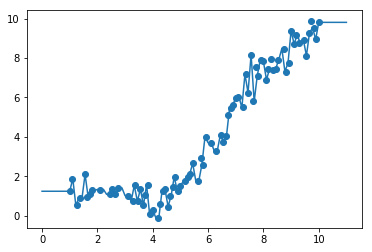

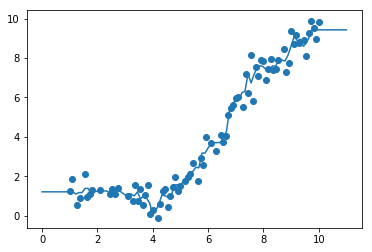

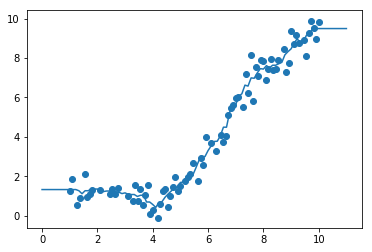

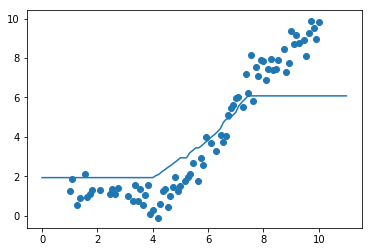

In [161]:
from scipy import spatial as sp
from sklearn import metrics as skm


if __name__ == "__main__":
    np.random.seed(521)
    Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
    randIdx = np.arange(100)
    np.random.shuffle(randIdx)
    trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
    validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
    testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

    # convert numpy array to tensors
    trainData = tf.stack(trainData)
    trainTarget = tf.stack(trainTarget)
    testData = tf.stack(testData)
    testTarget = tf.stack(testTarget)
    validData = tf.stack(validData)
    validtarget = tf.stack(validTarget)
    
    init = tf.global_variables_initializer()
    sessMain = tf.InteractiveSession()
    sessMain.run(init)
    
    
    
    plotResult(trainData, trainTarget)
    
    '''
    loss_test = testKValuesKNN(trainData, trainTarget, testData, testTarget)
    print("loss_test", loss_test)
    
    loss_train = testKValuesKNN(trainData, trainTarget, trainData, trainTarget)
    print("loss_train" , loss_train)
    
    loss_valid = testKValuesKNN(trainData, trainTarget, validData, validTarget)
    print("loss_valid", loss_valid)
    
    '''
    
    



        

## Loss on KNN
k  1 ,3 ,5 50
test 0.12799977712101845, 0.14242504248546536, 0.18633105926605592, 0.70693467047889302
train 0.0, 0.10825207710580038, 0.12183845521874122, 1.2477892734500411
valid 0.28807977607463453, 0.30897640431136369, 0.31043863052707066, 1.2230445257949047

## A1 Q2 Face